In [1]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(ComplexHeatmap)
  library(patchwork)
  library(rjson)
  library(parallel)
  library(ggplotify)
  library(biomaRt)
  library(ggsci)
  library(tidyverse)
})

In [57]:
setwd("/NAS392047/projects/yujw/2021.05.21.dingsheng/2Cell.induce/")

In [58]:
readComputeMatrixResult<-function(dfPath,offset=6){
  library(rjson)
  library(tidyverse)
  
  df<-read_tsv(file=dfPath,col_names=F,col_types=cols(),skip=1)
  metadata<-readLines(gzfile(dfPath),1)%>%str_remove("^@")%>%fromJSON(json_str=.)
  dfSplited<-list()
  for(i in 1:length(metadata$sample_labels)){
    dfSplited<-c(
      dfSplited,
      df[
        (offset+1  +  metadata$sample_boundaries[i]):
        (offset  +  metadata$sample_boundaries[i+1])
      ]%>%list
    )
  }
  names(dfSplited)<-metadata$sample_labels
  return(dfSplited)
}

In [59]:
dfList<-readComputeMatrixResult("computeMatrix/allStage.matrix.gz")

In [60]:
peakSum<-sapply(dfList[c("mESC","TLC","2Cell","ICM")],function(x){return(x%>%rowSums)})
peakSum%>%head

mESC,TLC,2Cell,ICM
413.5512,1777.7629,331.67041,457.84588
173.4229,1704.3769,251.48914,187.82391
103.4045,1470.2364,121.67695,65.20888
475.2849,2351.7469,312.40885,201.59232
321.9912,1538.4432,643.89839,362.52348
35.2035,340.6404,53.59326,11.10614


In [61]:
peakSum<-peakSum%>%
as.data.frame%>%
mutate(
  ifIdentical=case_when(
    ((mESC < TLC) & (ICM < `2Cell`)) ~ TRUE,
    TRUE ~ FALSE
  )
)

In [62]:
peakSum%>%select(ifIdentical) %>% write_tsv(file = "up.summit.filter", col_names = FALSE)

In [63]:
t1<-dfList[[1]]%>%as.matrix
t1[is.na(t1)]<-0

In [64]:
zMinZMaxList<-mclapply(dfList, function(x){
  x<-x%>%as.matrix
  x[is.na(x)]<-0
  min=quantile(x,.01)
  max=quantile(x,.98)
  return(list(min,max))
},mc.cores=100)

In [65]:
ownData<-dfList[c("mESC","TLC")]
xieweiData<-dfList[!names(dfList) %in% c("mESC","TLC")]

In [96]:
get98Percentile<-function(dfList){
  bigMtx<-reduce(dfList,cbind)
  return(quantile(bigMtx%>%as.matrix,0.98))
}

In [97]:
own98<-get98Percentile(ownData)
xiewei98<-get98Percentile(xieweiData)

In [98]:
own98
xiewei98

98% 
23.07689

98% 
9.671383

In [69]:
zMinZMaxList

$mESC
$mESC[[1]]
1% 
 0 

$mESC[[2]]
     98% 
21.05692 


$TLC
$TLC[[1]]
1% 
 0 

$TLC[[2]]
     98% 
25.42128 


$`2Cell_Early`
$`2Cell_Early`[[1]]
1% 
 0 

$`2Cell_Early`[[2]]
     98% 
7.275341 


$`2Cell`
$`2Cell`[[1]]
1% 
 0 

$`2Cell`[[2]]
    98% 
11.7098 


$`4Cell`
$`4Cell`[[1]]
1% 
 0 

$`4Cell`[[2]]
     98% 
9.148935 


$`8Cell`
$`8Cell`[[1]]
1% 
 0 

$`8Cell`[[2]]
    98% 
10.4503 


$ICM
$ICM[[1]]
1% 
 0 

$ICM[[2]]
     98% 
9.992367

In [70]:
zMaxList<-sapply(zMinZMaxList,function(x){x[[2]]})

In [71]:
zMaxList

mESC.98%         TLC.98% 2Cell_Early.98%       2Cell.98%       4Cell.98% 
      21.056919       25.421275        7.275341       11.709797        9.148935 
      8Cell.98%         ICM.98% 
      10.450301        9.992367

In [72]:
zMaxList%>%as.character%>%writeLines("computeMatrix/allStageZMaxList.txt")

In [86]:
zMaxList[c(1,2)]%>%mean
zMaxList[c(3:7)]%>%mean

[1] 23.2391

[1] 9.715348

# all stage but region is tss +- 5000

In [41]:
peakSummitHeatmap<-read_tsv("heatmap/allStageTSS.matrix.gz",col_names = F,col_types = cols(),skip = 1)

In [42]:
regionInfo<-peakSummitHeatmap[1:6]

In [43]:
pureDataMatrix<-peakSummitHeatmap%>%select(X7:X7006)

In [44]:
pureDataMatrix[is.na(pureDataMatrix)]<-0

In [45]:
pureDataMatrix<-pureDataMatrix%>%rename_with(function(x){newColNumber<-(str_extract(x,"(?<=X)\\d+")%>%as.numeric) - 6;paste0("X",as.character(newColNumber))})

In [46]:
seq(1,6001,1000)

[1]    1 1001 2001 3001 4001 5001 6001

In [47]:
dataMatrixList<-mapply(function(x){pureDataMatrix[x:(x+999)]},seq(1,6001,1000), SIMPLIFY = F)

In [48]:
zMinZMaxList<-mclapply(dataMatrixList, function(x){
  x<-x%>%as.matrix
  min=quantile(x,.01)
  max=quantile(x,.98)
  return(list(min,max))
},mc.cores=100)

In [49]:
zMinZMaxList

[[1]]
[[1]][[1]]
1% 
 0 

[[1]][[2]]
    98% 
61.2391 


[[2]]
[[2]][[1]]
1% 
 0 

[[2]][[2]]
    98% 
44.5813 


[[3]]
[[3]][[1]]
1% 
 0 

[[3]][[2]]
 98% 
5.55 


[[4]]
[[4]][[1]]
1% 
 0 

[[4]][[2]]
  98% 
7.854 


[[5]]
[[5]][[1]]
1% 
 0 

[[5]][[2]]
 98% 
6.08 


[[6]]
[[6]][[1]]
1% 
 0 

[[6]][[2]]
 98% 
5.65 


[[7]]
[[7]][[1]]
1% 
 0 

[[7]][[2]]
  98% 
5.817

In [50]:
zMaxList<-sapply(zMinZMaxList,function(x){x[[2]]})

In [51]:
zMaxList

98%     98%     98%     98%     98%     98%     98% 
61.2391 44.5813  5.5500  7.8540  6.0800  5.6500  5.8170

In [52]:
zMaxList%>%as.character%>%writeLines("heatmap/allStageTSSZMaxList.txt")

## turn dataMatrixList and get all row sum

In [10]:
tssReadSumList<-dataMatrixList%>%lapply(rowSums)

In [11]:
tssReadSumList%>%length

[1] 7

In [12]:
tssReadSum<-data.frame(tssReadSumList)
colnames(tssReadSum)<-c('TLCs','mESC','2Cell Early','2Cell','4Cell','8Cell','ICM')

In [13]:
tssReadSum.bak<-tssReadSum

In [22]:
tssReadSumNormalized<-tssReadSum%>%apply(MARGIN = 2, FUN = function(x){
  x/quantile(x,.99)
})

In [28]:
tssReadSumNormalized%>%nrow

[1] 32123

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.



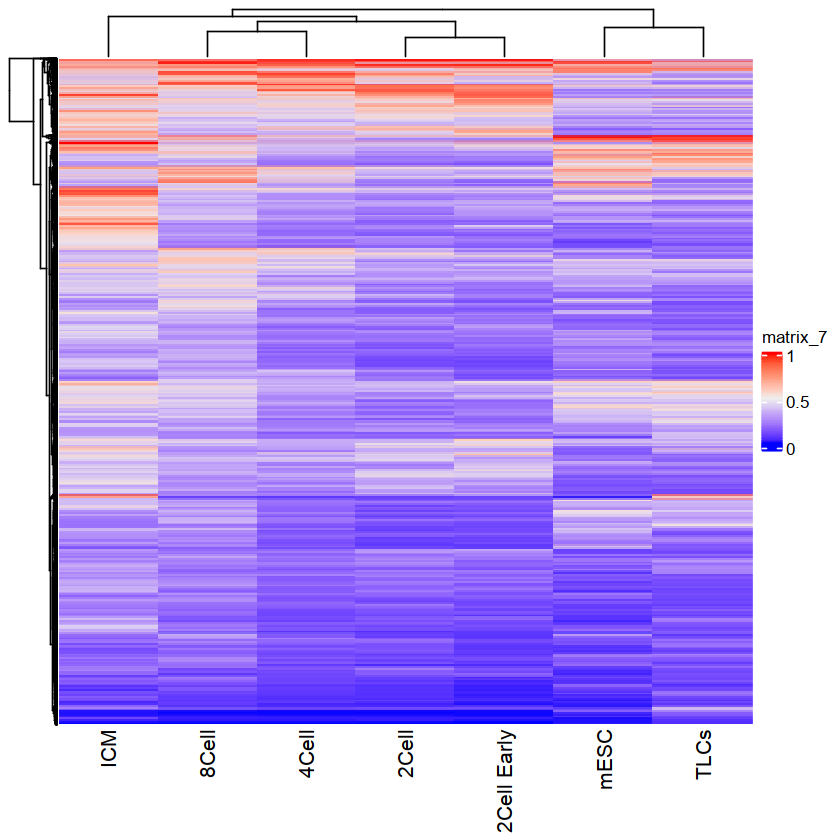

In [29]:
Heatmap(matrix = tssReadSumNormalized,use_raster = T,cluster_rows = T,cluster_columns = T)

## heatmap of stage markers

In [41]:
stageMarker<-read_tsv('heatmap/stageMarker.tsv',col_type=cols(),col_names = F)

In [50]:
colnames(stageMarker)<-c('2Cell','4Cell','8Cell','ICM');
stageMarkerList<-lapply(1:4,function(x){stageMarker[[x]]})
names(stageMarkerList)<-colnames(stageMarker)
stageMarkerList<-lapply(stageMarkerList,function(x){x[!is.na(x)]})

In [55]:
stageMarkerList%>%unlist%>%writeLines('stageMarkerGene.list')

In [57]:
allStageMarker<-stageMarkerList%>%unlist

In [63]:
ensembl<-useEnsembl(biomart = 'genes')
listDatasets(ensembl)%>%filter(str_detect(dataset,'mus'))
ensembl<-useDataset(dataset="mmusculus_gene_ensembl",mart=ensembl)

dataset,description,version
<I<chr>>,<I<chr>>,<I<chr>>
bmusculus_gene_ensembl,Blue whale genes (mBalMus1.v2),mBalMus1.v2
mmusculus_gene_ensembl,Mouse genes (GRCm39),GRCm39
psimus_gene_ensembl,Greater bamboo lemur genes (Prosim_1.0),Prosim_1.0
smaximus_gene_ensembl,Turbot genes (ASM1334776v1),ASM1334776v1
umaritimus_gene_ensembl,Polar bear genes (UrsMar_1.0),UrsMar_1.0


In [70]:
searchFilters(mart=ensembl,pattern="symbol")

,name,description
,<chr>,<chr>
67,hgnc_symbol,HGNC symbol(s) [e.g. ARVCF]
71,mgi_symbol,MGI symbol(s) [e.g. 0610005C13Rik]
95,uniprot_gn_symbol,UniProtKB Gene Name symbol(s) [e.g. 0610009B22Rik]


In [75]:
allStageMarker%>%length

[1] 1547

In [76]:
mm9TSS<-read_tsv('gencode.vM1.annotation.gene.tss.bed',col_types = cols(),col_names = F)

In [86]:
ensemblToSymbol<-getBM(
  attributes=c('ensembl_gene_id','external_gene_name'),
  filters=c('ensembl_gene_id'),
  mm9TSS$X4%>%str_extract(".*(?=\\.)"),
  mart=ensembl
)


Batch submitting query [===>---------------------------]  12% eta: 12s

Batch submitting query [=======>-----------------------]  25% eta: 10s

Batch submitting query [===========>-------------------]  38% eta:  8s

Batch submitting query [===============>---------------]  50% eta:  6s

Batch submitting query [==================>------------]  62% eta:  5s

Batch submitting query [======================>--------]  75% eta:  3s

Batch submitting query [==========================>----]  88% eta:  2s
                                                                      



In [87]:
mm9TSSToSymbol<-mm9TSS%>%
mutate(ensembl_gene_id=X4%>%str_extract(".*(?=\\.)"))%>%
left_join(ensemblToSymbol,by = 'ensembl_gene_id')

In [117]:
## write to bed and computeMatrix in shell
allStageMarkerBed<-mm9TSSToSymbol%>%filter(external_gene_name %in% allStageMarker)%>%
as.data.frame%>%
dplyr::select(c(X1,X2,X3,external_gene_name))

allStageMarkerBed%>%write_tsv(file = "allStageMarkerSymbol.bed",col_names = F)

In [ ]:
## read the computeMatrix result

In [96]:
peakSummitHeatmap<-read_tsv("heatmap/allStageMarkerTSS.matrix.gz",col_names = F,col_types = cols(),skip = 1)

In [99]:
regionInfo<-peakSummitHeatmap[1:6];regionInfo%>%head

X1,X2,X3,X4,X5,X6
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1,4847774,4847775,chr1:4847774-4847775,.,.
chr1,6196277,6196278,chr1:6196277-6196278,.,.
chr1,9535488,9535489,chr1:9535488-9535489,.,.
chr1,10222750,10222751,chr1:10222750-10222751,.,.
chr1,13117243,13117244,chr1:13117243-13117244,.,.
chr1,15795738,15795739,chr1:15795738-15795739,.,.


In [102]:
pureDataMatrix<-peakSummitHeatmap%>%dplyr::select(X7:X7006)

In [103]:
pureDataMatrix[is.na(pureDataMatrix)]<-0

In [104]:
pureDataMatrix<-pureDataMatrix%>%rename_with(function(x){newColNumber<-(str_extract(x,"(?<=X)\\d+")%>%as.numeric) - 6;paste0("X",as.character(newColNumber))})

In [105]:
seq(1,6001,1000)

[1]    1 1001 2001 3001 4001 5001 6001

In [106]:
dataMatrixList<-mapply(function(x){pureDataMatrix[x:(x+999)]},seq(1,6001,1000), SIMPLIFY = F)

In [107]:
tssReadSumList<-dataMatrixList%>%lapply(rowSums)

In [108]:
tssReadSumList%>%length

[1] 7

In [109]:
tssReadSum<-data.frame(tssReadSumList)
colnames(tssReadSum)<-c('TLCs','mESC','2Cell Early','2Cell','4Cell','8Cell','ICM')

In [110]:
tssReadSum.bak<-tssReadSum

In [111]:
tssReadSumNormalized<-tssReadSum%>%apply(MARGIN = 2, FUN = function(x){
  x/quantile(x,.99)
})

In [112]:
tssReadSumNormalized%>%nrow

[1] 1480

In [118]:
rownames(tssReadSumNormalized)<-allStageMarkerBed$external_gene_name

In [ ]:
stageMarkerList$

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.



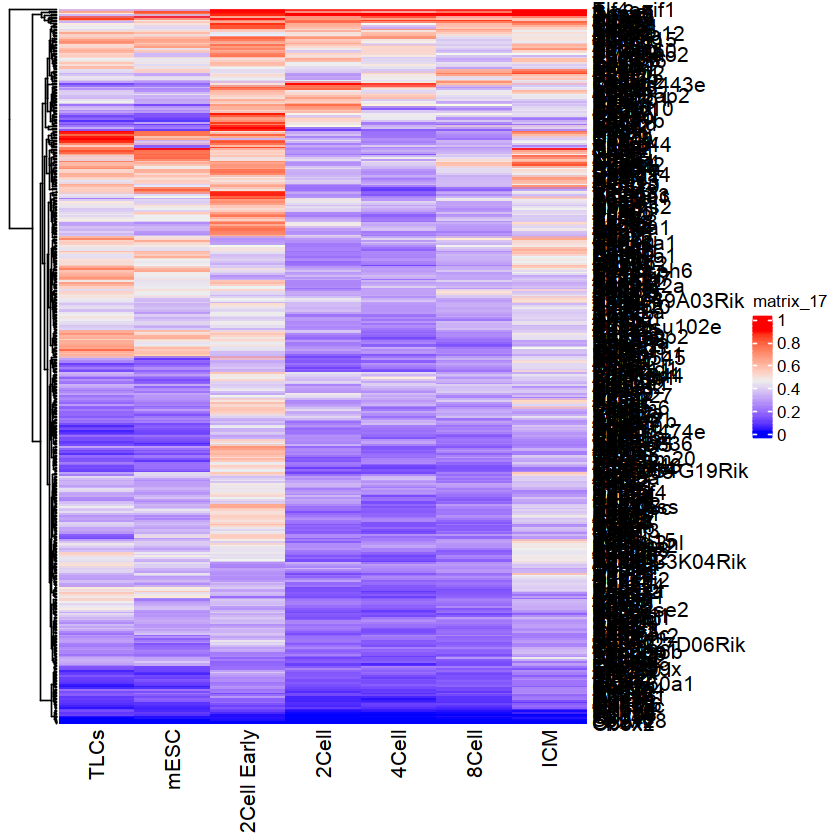

In [126]:
Heatmap(matrix = tssReadSumNormalized[rownames(tssReadSumNormalized)%in%stageMarkerList$`2Cell`,],use_raster = T,cluster_rows = T,cluster_columns =F)

## all stage, compute global zmax, for seperate plot

In [5]:
peakSummitHeatmap<-read_tsv("heatmap/allStage.all_forComputeZminAndZmax_.matrix.gz",col_names = F,col_types = cols(),skip = 1)

In [6]:
regionInfo<-peakSummitHeatmap[1:6]

In [7]:
pureDataMatrix<-peakSummitHeatmap%>%select(X7:X7006)

In [8]:
pureDataMatrix[is.na(pureDataMatrix)]<-0

In [9]:
pureDataMatrix<-pureDataMatrix%>%rename_with(function(x){newColNumber<-(str_extract(x,"(?<=X)\\d+")%>%as.numeric) - 6;paste0("X",as.character(newColNumber))})

In [10]:
seq(1,6001,1000)

[1]    1 1001 2001 3001 4001 5001 6001

In [11]:
dataMatrixList<-mapply(function(x){pureDataMatrix[x:(x+999)]},seq(1,6001,1000), SIMPLIFY = F)

In [24]:
zMinZMaxList<-mclapply(dataMatrixList, function(x){
  x<-x%>%as.matrix
  min=quantile(x,.01)
  max=quantile(x,.98)
  return(list(min,max))
},mc.cores=100)

ERROR: Error in mclapply(dataMatrixList, function(x) {: object 'dataMatrixList' not found


In [13]:
zMinZMaxList

[[1]]
[[1]][[1]]
1% 
 0 

[[1]][[2]]
  98% 
63.59 


[[2]]
[[2]][[1]]
1% 
 0 

[[2]][[2]]
     98% 
49.89873 


[[3]]
[[3]][[1]]
1% 
 0 

[[3]][[2]]
  98% 
5.959 


[[4]]
[[4]][[1]]
1% 
 0 

[[4]][[2]]
 98% 
8.39 


[[5]]
[[5]][[1]]
1% 
 0 

[[5]][[2]]
     98% 
6.556667 


[[6]]
[[6]][[1]]
1% 
 0 

[[6]][[2]]
  98% 
6.395 


[[7]]
[[7]][[1]]
1% 
 0 

[[7]][[2]]
  98% 
6.741

In [14]:
zMaxList<-sapply(zMinZMaxList,function(x){x[[2]]})

In [15]:
zMaxList

98%       98%       98%       98%       98%       98%       98% 
63.590000 49.898732  5.959000  8.390000  6.556667  6.395000  6.741000

In [16]:
zMaxList%>%as.character%>%writeLines("heatmap/allStageZMaxList.txt")

In [20]:
ggsci::pal_locuszoom()(1)

[1] "#D43F3AFF"

## Read Up and Down section of the plot and plot relavant lineplot

### Up

In [159]:
peakSummitHeatmap<-read_tsv("heatmap/allStage.up.matrix.gz",col_names=F,col_types=cols(),skip=1)
regionInfo<-peakSummitHeatmap[1:6]
pureDataMatrix<-peakSummitHeatmap%>%select(X7:X7006)
pureDataMatrix[is.na(pureDataMatrix)]<-0
pureDataMatrix<-pureDataMatrix%>%rename_with(function(x){newColNumber<-(str_extract(x,"(?<=X)\\d+")%>%as.numeric) - 6;paste0("X",as.character(newColNumber))})
sampleSeperator=seq(1,6001,1000)
dataMatrixList<-lapply(sampleSeperator,function(x){pureDataMatrix[x:(x+999)]})

In [160]:
signalDistributionList<-lapply(dataMatrixList,function(dataMatrix){
  wide=apply(X = dataMatrix, MARGIN = 2, FUN = mean)
  long=as.data.frame(wide)
  long=long%>%mutate(relativeCoordinate=(row_number()-nrow(long)/2)*10 )
})

In [161]:
nameList<-c("mESC","TLC","2Cell Early", "2Cell","4Cell","8Cell","ICM")

In [162]:
plotList<-list()
for(i in 1:length(nameList)){
  zmin=zMinZMaxList[[i]][[1]]
  zmax=zMinZMaxList[[i]][[2]]
  ybreaks<-c(zmin,(zmin+zmax)/3,(zmin+zmax)*2/3, zmax)
  ylabels<-c(0,"33%", "67%", "98%")
  ylimits<-c(zmin,zmax*1.2)
  
  ggplot(data=signalDistributionList[[i]])+
  geom_line(aes(x=relativeCoordinate,y=wide),color=ggsci::pal_locuszoom()(5)[5],size=0.6)+
  labs(title = nameList[[i]])+
  ylab(label = "signal strength percentile")+
  xlab(label = "")+
  scale_y_continuous(
    limits = ylimits,
    expand=c(0,0),
    breaks=ybreaks,
    labels=ylabels
  )+
  scale_x_continuous(
    expand=c(0,0),
    breaks=c()
  )+
  theme_classic()+
  theme(
    panel.border=element_rect(color="black",fill=NA,size=0.5),
    axis.ticks=element_blank(),
    axis.line=(element_blank())
  )+
  coord_fixed(1e4/(ylimits[2]-ylimits[1]))
  plotList<-c(plotList,last_plot()%>%list)
}

In [163]:
plotList%>%wrap_plots()%>%ggsave(filename = "up.lineplot.pdf",w=7,h=7)

### Down

In [164]:
peakSummitHeatmap<-read_tsv("heatmap/allStage.down.matrix.gz",col_names=F,col_types=cols(),skip=1)
regionInfo<-peakSummitHeatmap[1:6]
pureDataMatrix<-peakSummitHeatmap%>%select(X7:X7006)
pureDataMatrix[is.na(pureDataMatrix)]<-0
pureDataMatrix<-pureDataMatrix%>%rename_with(function(x){newColNumber<-(str_extract(x,"(?<=X)\\d+")%>%as.numeric) - 6;paste0("X",as.character(newColNumber))})
sampleSeperator=seq(1,6001,1000)
dataMatrixList<-lapply(sampleSeperator,function(x){pureDataMatrix[x:(x+999)]})

In [165]:
signalDistributionList<-lapply(dataMatrixList,function(dataMatrix){
  wide=apply(X = dataMatrix, MARGIN = 2, FUN = mean)
  long=as.data.frame(wide)
  long=long%>%mutate(relativeCoordinate=(row_number()-nrow(long)/2)*10 )
})

In [166]:
nameList<-c("mESC","TLC","2Cell Early", "2Cell","4Cell","8Cell","ICM")

In [167]:
plotList<-list()
for(i in 1:length(nameList)){
  zmin=zMinZMaxList[[i]][[1]]
  zmax=zMinZMaxList[[i]][[2]]
  ybreaks<-c(zmin,(zmin+zmax)/3,(zmin+zmax)*2/3, zmax)
  ylabels<-c(0,"33%", "67%", "98%")
  ylimits<-c(zmin,zmax*1.2)
  
  ggplot(data=signalDistributionList[[i]])+
  geom_line(aes(x=relativeCoordinate,y=wide),color=ggsci::pal_locuszoom()(5)[5],size=0.6)+
  labs(title = nameList[[i]])+
  ylab(label = "signal strength percentile")+
  xlab(label = "")+
  scale_y_continuous(
    limits = ylimits,
    expand=c(0,0),
    breaks=ybreaks,
    labels=ylabels
  )+
  scale_x_continuous(
    expand=c(0,0),
    breaks=c()
  )+
  theme_classic()+
  theme(
    panel.border=element_rect(color="black",fill=NA,size=0.5),
    axis.ticks=element_blank(),
    axis.line=(element_blank())
  )+
  coord_fixed(1e4/(ylimits[2]-ylimits[1]))
  plotList<-c(plotList,last_plot()%>%list)
}

In [168]:
plotList%>%wrap_plots()%>%ggsave(filename = "down.lineplot.pdf",w=7,h=7)